# Quanvolutional Neural Networks

El siguiente código sigue el paper de  [Henderson et al. (2019)](https://arxiv.org/abs/1904.04767). 

La idea es usar circuitos cuánticos variacionales (es decir con parámetros optimizables) como capas convolucionales dentro de la estructura de una [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network). Para ello se procede de la siguiente manera:

- Se toma una subregión de la imágen de 2x2, y se la codifica en el circuito cuántico. Para esto usamos rotaciones parametrizadas aplicadas a los quibts de entrada en $|0\rangle$.

- Se aplica una transformación unitaria U sobre todo el sistema. Esta unitaria puede generarse con un circuito cuántico variacional o con un circuito random.

- Se mide el sistema cuántico y se obtienen valores de expectación clásicos. 

- Cada valor de expectación se mapea a un canal distinto de un output de un pixel.

- Repetimos el proceso sobre las distintas regiones, escaneando la imágen completa y generando una imágen multicanal.

- Esta convolución entra dentro de una estructura tradicional de CNN, pudiendose agregar otras convoluciones clásicas o cuánticas.

La idea de fondo es que convoluciones cuánticas pueden encontrar tipos de patrones imposibles de emular clásicamente.

### Implementación con PennyLane

Instalamos PennyLane. Penylane es una librería especializada en quantum machine learning. Quizas sea necesario reiniciar el entorno de ejecución luego de instalar estos paquetes

In [1]:
%%capture
!pip install pennylane
!pip install pennylane-sf pennylane-qiskit

Importamos las librerías

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Definimos los hiperparámetros del problema

In [3]:
n_epochs = 30   # Número de epochs
n_layers = 1    # Número de layers random
n_train = 50    # Tamaño del dataset de entrenamiento
n_test = 30     # Tamaño del dataset de testeo

import os

SAVE_PATH = "quanvolution/" # Carpeta para guardar data
PREPROCESS = True           # Si Falso, salteo el quantum preprocessing y carga data de SAVE_PATH
np.random.seed(0)           # Semilla de número random de NumPy
tf.random.set_seed(0)       # Semilla de número random de TensorFlow

In [4]:
os.mkdir(SAVE_PATH)

Cargamos la data de MNIST. Acotamos la data para tener resultados más rápidos, pero no es necesario.

In [5]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reducimos el tamaño del dataset
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalizamos los valores de pixel entre 0 y 1
train_images = train_images / 255
test_images = test_images / 255

# Agregamos dimensión extra para canales convolucionales
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]

11493376/11490434 [==============================] - 0s 0us/step


Vamos a seguir el esquema de la imagen de abajo. Tenemos 4 qubits de entrada. Luego colocamos
- Rotaciones de forma proporcional a los pixeles de la imágen (escaleados en un factor de $\pi$)
- Un circuito random de n_layers
- Una medida para estimar 4 valores de expectación.

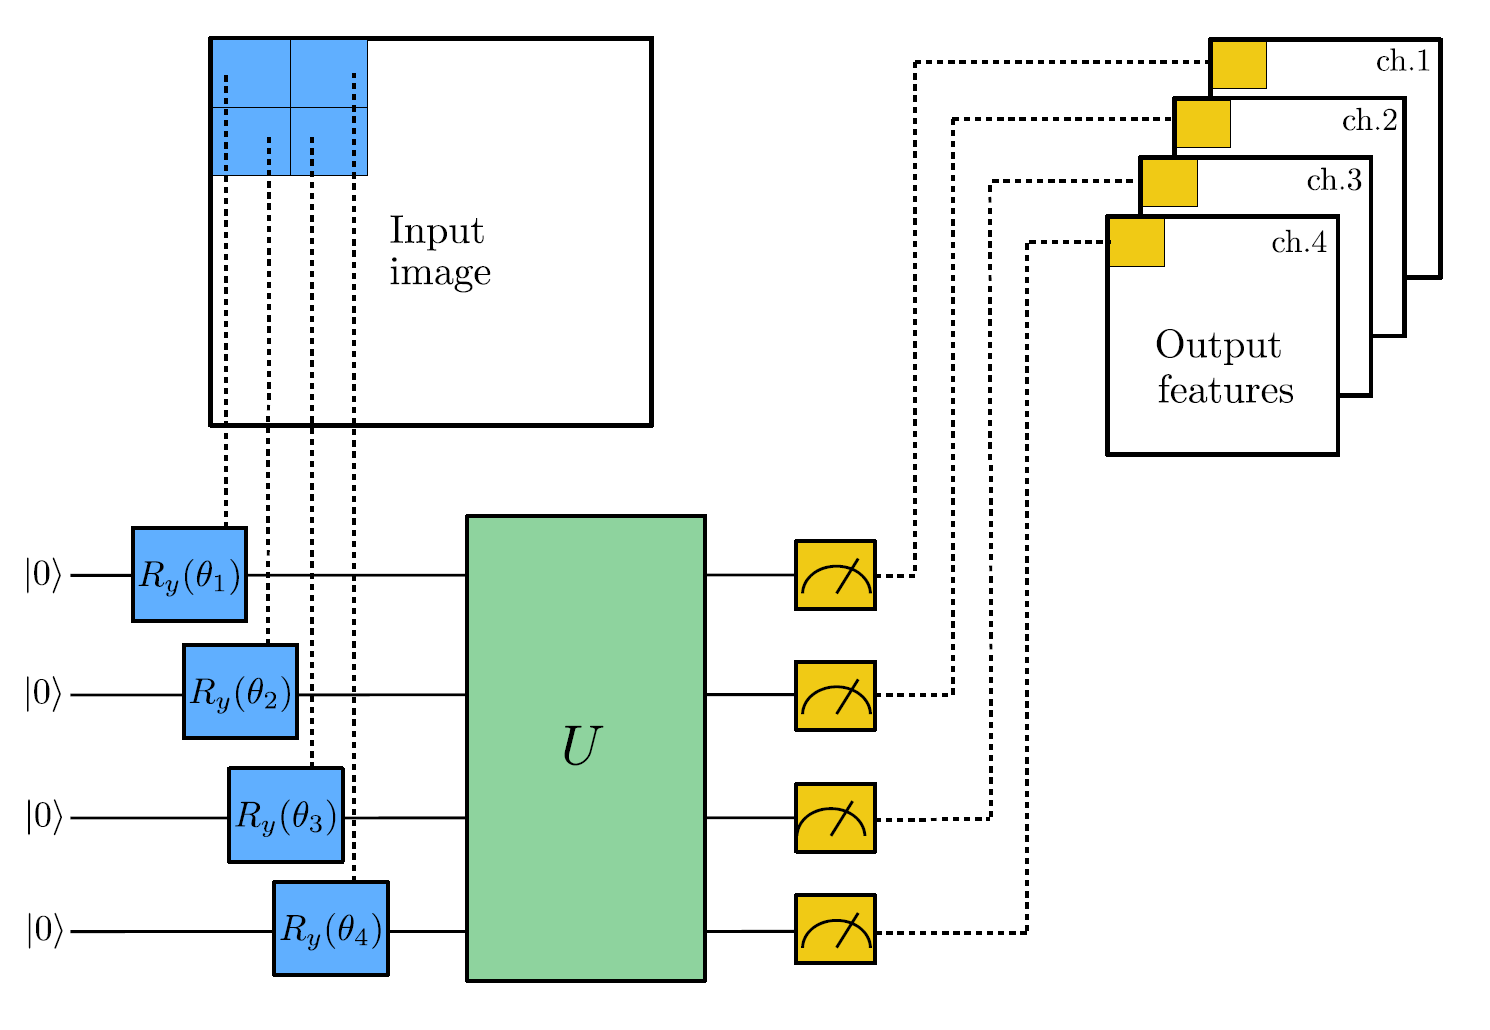

In [6]:
dev = qml.device("default.qubit", wires=4)
# Parametros random del circuito
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi=None):
    # Encodeamos 4 valores clásicos de input
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Circuito cuántico random
    RandomLayers(rand_params, wires=list(range(4)))

    # Medida que produce 4 valores de output clásicos
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

Creamos ahora el esquema de convolución:

- La imágen se divide en cuadrados de 2x2.
- Cada cuadrado se procesa con un circuito cuántico.
- Los 4 valores de expectación se mapean a 4 canales distintos de un pixel.

Esto divide la resolución de la imagen (corresponde a convolución con kernel de 2x2 y stride=2)

In [7]:
def quanv(image):
    """Convoluciona la imágen de input con muchas aplicaciones del mismo circuito cuántico."""
    out = np.zeros((14, 14, 4))

    # Loop sobre las coordenadas del pixel superior izquierdo con cuadrados de 2x2
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Procesamos una región de 2x2 de la imágen con el circuito cuántico
            q_results = circuit(
                phi=[
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Asignamos valores de expectación a diferentes canales del pixel de output (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Vamos a aplicar la convolución cuántica como un preprocesado de la imagen, en lugar de usarla como capa entrenable. Luego vamos a entrenar el modelo clásico sobre el dataset preprocesado, para evitar correr muchas veces sobre la computadora cuántica (esto se podría hacer, naturalmente, pero es caro).

In [8]:
if PREPROCESS == True:
    q_train_images = []
    print("Preprocesado cuántico de las imágenes de entrenamiento:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nPreprocesado cuántico de las imágenes de testeo:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Guardamos imágenes preprocesadas
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

# Cargamos imágenes preprocesadas
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Pre procesado cuántico de las imágenes de entrenamiento:

Pre procesado cuántico de las imágenes de testeo:


Visualicemos el efecto de la capa convolucional en las muestras:

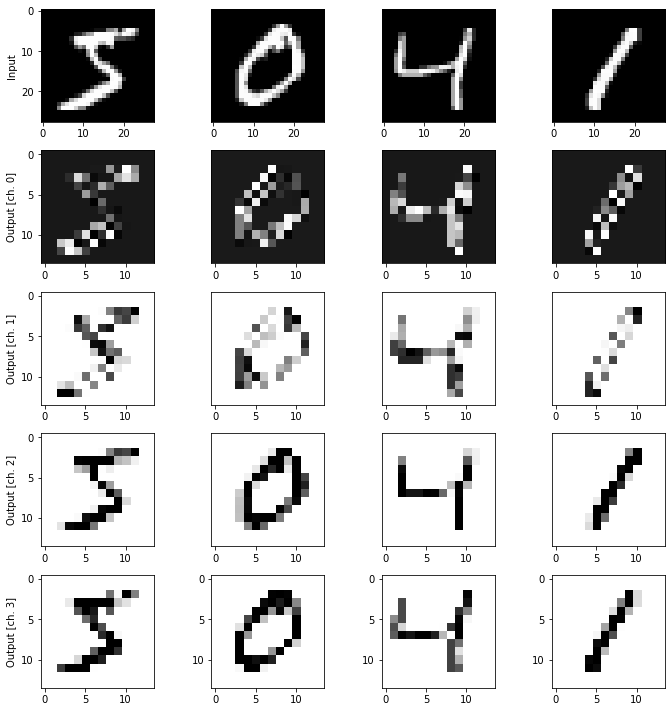

In [9]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Graficamos todos los canales de output
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Tenemos 4 grupos de imágenes correspondientes a los 4 canales. Se vé la bajada en la resolución. 

### Modelo híbrido

Vamos a alimentar con este preprocesado a una red neuronal clásica.  Usamos una capa fully connected, 10 outputs de salida con activación softmax. Elegimos  stochastic gradient descent como optimizador, y cross-entropy como función de pérdida.

In [10]:
def MyModel():
    """Inicializa y devuelve un modelo custom de Keras que está ya entrenado"""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Entrenamos

In [11]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.9351 - accuracy: 0.1000 - val_loss: 2.3946 - val_accuracy: 0.1000
Epoch 2/30
13/13 - 0s - loss: 2.1241 - accuracy: 0.2800 - val_loss: 2.1525 - val_accuracy: 0.2000
Epoch 3/30
13/13 - 0s - loss: 1.7218 - accuracy: 0.5600 - val_loss: 2.0267 - val_accuracy: 0.3333
Epoch 4/30
13/13 - 0s - loss: 1.3012 - accuracy: 0.6400 - val_loss: 1.7713 - val_accuracy: 0.4000
Epoch 5/30
13/13 - 0s - loss: 1.0990 - accuracy: 0.8000 - val_loss: 1.6480 - val_accuracy: 0.4333
Epoch 6/30
13/13 - 0s - loss: 0.9181 - accuracy: 0.8000 - val_loss: 1.6461 - val_accuracy: 0.3667
Epoch 7/30
13/13 - 0s - loss: 0.7147 - accuracy: 0.9400 - val_loss: 1.5006 - val_accuracy: 0.4667
Epoch 8/30
13/13 - 0s - loss: 0.5779 - accuracy: 0.9600 - val_loss: 1.4361 - val_accuracy: 0.5333
Epoch 9/30
13/13 - 0s - loss: 0.4889 - accuracy: 0.9600 - val_loss: 1.4047 - val_accuracy: 0.4667
Epoch 10/30
13/13 - 0s - loss: 0.3953 - accuracy: 1.0000 - val_loss: 1.3868 - val_accuracy: 0.6000
Epoch 11/30
13/13 -

Queremos ahora comprarar los resultado con y sin la capa convolucional cuántica:

In [12]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.3920 - accuracy: 0.1000 - val_loss: 2.3593 - val_accuracy: 0.0333
Epoch 2/30
13/13 - 0s - loss: 2.0247 - accuracy: 0.2600 - val_loss: 2.1961 - val_accuracy: 0.1000
Epoch 3/30
13/13 - 0s - loss: 1.7295 - accuracy: 0.5200 - val_loss: 2.0452 - val_accuracy: 0.2000
Epoch 4/30
13/13 - 0s - loss: 1.4920 - accuracy: 0.7400 - val_loss: 1.8979 - val_accuracy: 0.3000
Epoch 5/30
13/13 - 0s - loss: 1.2813 - accuracy: 0.8800 - val_loss: 1.7643 - val_accuracy: 0.5000
Epoch 6/30
13/13 - 0s - loss: 1.1111 - accuracy: 0.9000 - val_loss: 1.6653 - val_accuracy: 0.5000
Epoch 7/30
13/13 - 0s - loss: 0.9656 - accuracy: 0.9200 - val_loss: 1.5896 - val_accuracy: 0.5667
Epoch 8/30
13/13 - 0s - loss: 0.8459 - accuracy: 0.9400 - val_loss: 1.5169 - val_accuracy: 0.6333
Epoch 9/30
13/13 - 0s - loss: 0.7474 - accuracy: 0.9400 - val_loss: 1.4564 - val_accuracy: 0.7000
Epoch 10/30
13/13 - 0s - loss: 0.6632 - accuracy: 0.9600 - val_loss: 1.4129 - val_accuracy: 0.7000
Epoch 11/30
13/13 -

Ploteamos la comparación

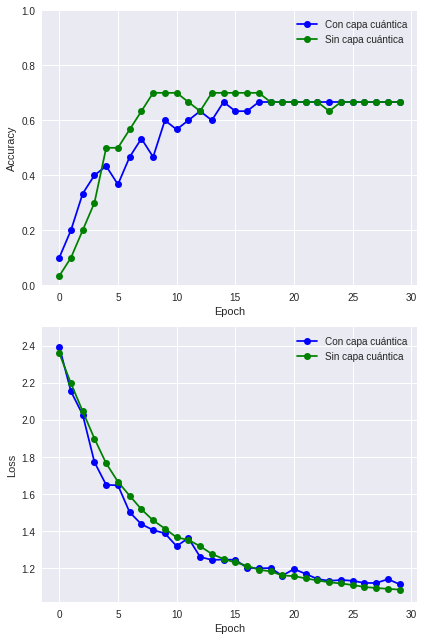

In [13]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="Con capa cuántica")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Sin capa cuántica")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="Con capa cuántica")
ax2.plot(c_history.history["val_loss"], "-og", label="Sin capa cuántica")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

Podemos ver una leve ventaja del modelo incorporando el preprocesado cuántico. 

Esta claro que no hay una mejora sustancial en este ejemplo. En el paper pueden apreciarse resultados un poco más contundentes, mostrando mejoras en precisión y tiempos de entrenamiento. 

Este modelo tiene como objetivo combinar conceptos de los dos mundos y abrir campos de investigación y no reemplazar modelos existentes de CNN. 